In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ray
import seaborn as sns
import math
sns.set_theme()
sns.set_style("white")
sns.set_style("ticks")
sns.set_style("ticks",{'axes.grid' : True})
import scienceplots
plt.style.use('science')
color_arr = ['#3F90DA', '#FFA90E', '#BD1F01', '#94A4A2', '#832DB6', '#A96B59', '#E76300', '#B9AC70', '#92DADD']
try:
    import cPickle as pickle
except ImportError:
    import pickle

In [2]:
def Metropolis_Function_PBC(S, E, J, B, beta, L): 
    # Place flip at some location in the domain 
    ii = (np.random.randint(L) ) % L ## 
    jj = (np.random.randint(L) ) % L

    ### First flip external field contribution
    dE = 2 * B * S[ii, jj] 
    ## Then Flip Neighbors
    for di, dj in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
                dE += 2 * J * S[ii, jj] * S[(ii + di) % L, (jj + dj) % L]
    # Metropolis Transition
    if(dE <= 0):
        flip = True
    else:
        p = np.exp(-beta*dE)
        if np.random.rand() < p:
            flip = True
        else:
            flip = False

    if(flip == True):
        E += dE
        S[ii, jj] *= -1 # Flip 
    return S, E

In [3]:
# Parallelization Function
@ray.remote
def run_simulation(L, beta, total_iters, equilibration_steps, J, B):
    S = np.random.choice([-1, 1], size=(L, L))
    E = -J * np.sum(S * (np.roll(S, 1, axis=0) + np.roll(S, 1, axis=1))) + -B * np.sum(S)
    m_arr = []
    E_arr = []
    initE = float('inf')
    stab_cond = 0
    tol_break = 100000

    # Equilibration
    for i in range(0, equilibration_steps):
        S, E = Metropolis_Function_PBC(S, E, J, B, beta, L)
        initE = E 

    # Measurement
    for i in range(0, total_iters - equilibration_steps):
        S, E = Metropolis_Function_PBC(S, E, J, B, beta, L )
        m_arr.append(np.sum(S))
        E_arr.append(E)

        if E == initE:
            stab_cond += 1
            if stab_cond >= tol_break:
                print(f"L={L}, log10(beta)={np.log10(beta):.2f}: Energy diff reached tol after {equilibration_steps + i + 1} steps.")
                break
        else:
            stab_cond = 0
            initE = E
            
    ## Returning Densities
    return m_arr, E_arr ### returning full arrays of magnetization instead

# Ray v3

In [4]:
ray.shutdown()

2025-05-06 18:22:56,996	INFO worker.py:1660 -- Connecting to existing Ray cluster at address: 192.168.110.194:6379...
2025-05-06 18:22:57,005	INFO worker.py:1843 -- Connected to Ray cluster. View the dashboard at http://127.0.0.1:8265 


Submitting tasks for L = 100
Retrieving results...
L=100, log10(beta)=-0.20, collected 1800001 magnetization samples.
L=100, log10(beta)=-0.20, collected 1800001 magnetization samples.
L=100, log10(beta)=-0.20, collected 1800001 magnetization samples.
L=100, log10(beta)=-0.20, collected 1800001 magnetization samples.
L=100, log10(beta)=-0.20, collected 1800001 magnetization samples.
L=100, log10(beta)=-0.21, collected 1800001 magnetization samples.
L=100, log10(beta)=-0.21, collected 1800001 magnetization samples.
L=100, log10(beta)=-0.21, collected 1800001 magnetization samples.
L=100, log10(beta)=-0.21, collected 1800001 magnetization samples.
L=100, log10(beta)=-0.21, collected 1800001 magnetization samples.
L=100, log10(beta)=-0.21, collected 1800001 magnetization samples.
L=100, log10(beta)=-0.21, collected 1800001 magnetization samples.
L=100, log10(beta)=-0.21, collected 1800001 magnetization samples.
L=100, log10(beta)=-0.22, collected 1800001 magnetization samples.
L=100, log1

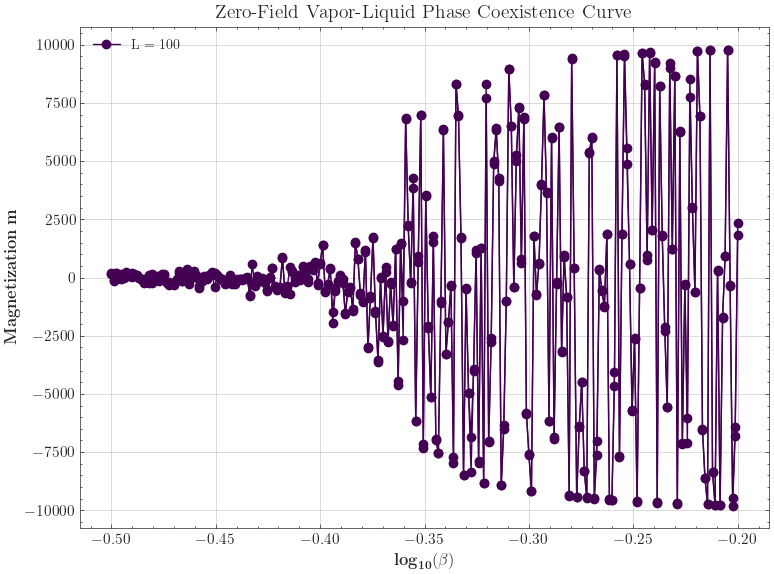

In [5]:
# Initial Conditions
J = 1
B = 0.0
exp_arr = np.linspace(-0.5, -0.2, 250)
beta_arr = np.flip(10**exp_arr)
L_arr = [100] 
iters_arr = [18000001, 18000001, 18000001]

ray.init()

futures = []
equilibration_fraction = 0.9
for l_idx, L in enumerate(L_arr):
    print(f'Submitting tasks for L = {L}')
    total_iters = iters_arr[l_idx]
    equilibration_steps = int(total_iters * equilibration_fraction)
    for beta in beta_arr:
        future = run_simulation.remote(L, beta, total_iters, equilibration_steps, J, B)
        futures.append((L, beta, future))

magnetization_histories = {L: {} for L in L_arr}

print("Retrieving results...")
for L, beta, future in futures:
    m_history, _ = ray.get(future)
    magnetization_histories[L][beta] = np.array(m_history)
    print(f"L={L}, log10(beta)={np.log10(beta):.2f}, collected {len(m_history)} magnetization samples.")

ray.shutdown()

# Plotting the Coexistence Curve
plt.figure(figsize=(8, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(L_arr)))

for i, L in enumerate(sorted(L_arr)):
    coexistence_plus = []
    coexistence_minus = []
    beta_coexistence = []
    sorted_betas = sorted(magnetization_histories[L].keys())

    for beta in sorted_betas:
        m_hist = magnetization_histories[L][beta]
        if len(m_hist) > 0:
            hist, bins = np.histogram(m_hist, bins=50, density=True)
            peak_indices = np.argsort(hist)[::-1][:2] 
            if len(peak_indices) == 2:
                peak1 = (bins[peak_indices[0]] + bins[peak_indices[0] + 1]) / 2
                peak2 = (bins[peak_indices[1]] + bins[peak_indices[1] + 1]) / 2
                coexistence_plus.append(max(peak1, peak2))
                coexistence_minus.append(min(peak1, peak2))
                beta_coexistence.append(beta)
            elif len(peak_indices) == 1: 
                coexistence_plus.append(0)
                coexistence_minus.append(0)
                beta_coexistence.append(beta)
            else:
                coexistence_plus.append(np.mean(m_hist)) 
                coexistence_minus.append(np.mean(m_hist))
                beta_coexistence.append(beta)
        else:
            coexistence_plus.append(np.nan)
            coexistence_minus.append(np.nan)
            beta_coexistence.append(beta)

    plt.plot(np.log10(np.array(beta_coexistence)), np.array(coexistence_plus), marker='o', linestyle='-', color=colors[i], label=f'L = {L}')
    plt.plot(np.log10(np.array(beta_coexistence)), np.array(coexistence_minus), marker='o', linestyle='-', color=colors[i])

plt.xlabel(r'$\mathbf{\mathrm{\textbf{log}}_{10}(\beta)}$', fontsize=12)
plt.ylabel(r'$\mathbf{\mathrm{\textbf{Magnetization}} \, m}$', fontsize=12)
plt.title('Zero-Field Vapor-Liquid Phase Coexistence Curve', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

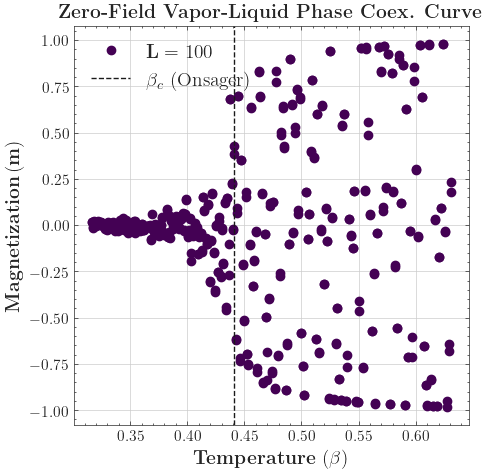

In [6]:
# Plotting the Coexistence Curve
plt.figure(figsize=(5, 5))
colors = plt.cm.viridis(np.linspace(0, 1, len(L_arr)))

for i, L in enumerate(sorted(L_arr)):
    coexistence_plus = []
    coexistence_minus = []
    beta_coexistence = []
    sorted_betas = sorted(magnetization_histories[L].keys())
    if(L != 10 and L != 1000):
        for beta in sorted_betas:
            m_hist = magnetization_histories[L][beta]
            # Analyze the distribution of m_hist to find the two peaks
            if len(m_hist) > 0:
                hist, bins = np.histogram(m_hist, bins=50, density=True)
                peak_indices = np.argsort(hist)[::-1][:2] # Get indices of the two largest bins (approximation)
                if len(peak_indices) == 2:
                    peak1 = (bins[peak_indices[0]] + bins[peak_indices[0] + 1]) / 2
                    peak2 = (bins[peak_indices[1]] + bins[peak_indices[1] + 1]) / 2
                    coexistence_plus.append(max(peak1, peak2))
                    coexistence_minus.append(min(peak1, peak2))
                    beta_coexistence.append(beta)
                elif len(peak_indices) == 1: # Above Tc, should be around zero
                    coexistence_plus.append(0)
                    coexistence_minus.append(0)
                    beta_coexistence.append(beta)
                else:
                    coexistence_plus.append(np.mean(m_hist)) # Fallback
                    coexistence_minus.append(np.mean(m_hist))
                    beta_coexistence.append(beta)
            else:
                coexistence_plus.append(np.nan)
                coexistence_minus.append(np.nan)
                beta_coexistence.append(beta)

        plt.plot((np.array(beta_coexistence)), np.array(coexistence_plus)/L**2, marker='o', linestyle='', color=colors[i], label=r'$\mathbf{L =}$' + f' {L}')
        plt.plot((np.array(beta_coexistence)), np.array(coexistence_minus)/L**2, marker='o', linestyle='', color=colors[i])

plt.xlabel(r'\textbf{Temperature} $(\beta)$', fontsize=14)
plt.ylabel(r'$\mathbf{\mathrm{\textbf{Magnetization}} \, (m)}$', fontsize=14)
plt.title(r'\textbf{Zero-Field Vapor-Liquid Phase Coex. Curve}', fontsize=14)
plt.axvline(x = .4407, color = 'k', linestyle = '--', label = r'$\beta_c$ (Onsager)')
plt.legend(fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig('Coexistence-curve.pdf')
plt.show()

In [8]:

str1 = f'Ising-Data/m_meanfield-WFp-temp.pkl'
with open(str1, 'rb') as f:
    m_mean_data_Lvar_NFp = pickle.load(f)


str1 = f'Ising-Data/m_meanfield-WFm-temp.pkl'
with open(str1, 'rb') as f:
    m_mean_data_Lvar_NFm = pickle.load(f)

str1 = f'Ising-Data/m_meanfield-WFm-temp_betaarr.pkl'
with open(str1, 'rb') as f:
    beta_arr_2 = pickle.load(f)


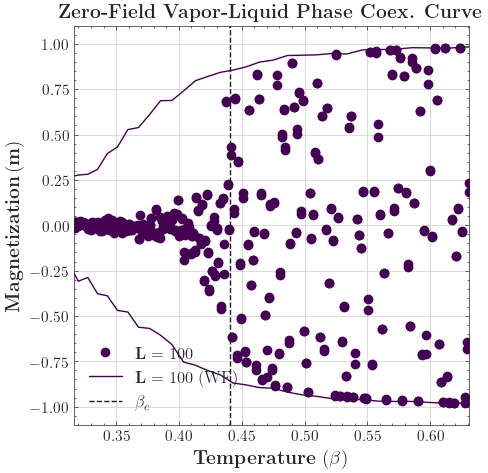

In [14]:
# Plotting the Coexistence Curve
plt.figure(figsize=(5, 5))
colors = plt.cm.viridis(np.linspace(0, 1, len(L_arr)))

for i, L in enumerate(sorted(L_arr)):
    coexistence_plus = []
    coexistence_minus = []
    beta_coexistence = []
    sorted_betas = sorted(magnetization_histories[L].keys())
    if(L != 1000):
    # if(L != 10 and L != 1000):
        for beta in sorted_betas:
            m_hist = magnetization_histories[L][beta]
            # Analyze the distribution of m_hist to find the two peaks
            if len(m_hist) > 0:
                hist, bins = np.histogram(m_hist, bins=50, density=True)
                peak_indices = np.argsort(hist)[::-1][:2] # Get indices of the two largest bins (approximation)
                if len(peak_indices) == 2:
                    peak1 = (bins[peak_indices[0]] + bins[peak_indices[0] + 1]) / 2
                    peak2 = (bins[peak_indices[1]] + bins[peak_indices[1] + 1]) / 2
                    coexistence_plus.append(max(peak1, peak2))
                    coexistence_minus.append(min(peak1, peak2))
                    beta_coexistence.append(beta)
                elif len(peak_indices) == 1: # Above Tc, should be around zero
                    coexistence_plus.append(0)
                    coexistence_minus.append(0)
                    beta_coexistence.append(beta)
                else:
                    coexistence_plus.append(np.mean(m_hist)) # Fallback
                    coexistence_minus.append(np.mean(m_hist))
                    beta_coexistence.append(beta)
            else:
                coexistence_plus.append(np.nan)
                coexistence_minus.append(np.nan)
                beta_coexistence.append(beta)

        plt.plot((np.array(beta_coexistence)), np.array(coexistence_plus)/L**2, marker='o', linestyle='', color=colors[i], label=r'$\mathbf{L =}$' + f' {L}')
        plt.plot((np.array(beta_coexistence)), np.array(coexistence_minus)/L**2, marker='o', linestyle='', color=colors[i])

N = 4
for i, L in enumerate(sorted(L_arr)):
    if(L != 10 and L != 1000):
    # if(L != 1000):
        plt.plot((beta_arr_2), (np.array(m_mean_data_Lvar_NFp[L])), color=colors[i], label=r'$\mathbf{L =}$' + f' {L} (WF)')
        plt.plot((beta_arr_2), (np.array(m_mean_data_Lvar_NFm[L])), color=colors[i])
plt.xlim(np.min(beta_arr), np.max(beta_arr))
plt.xlabel(r'\textbf{Temperature} $(\beta)$', fontsize=14)
plt.ylabel(r'$\mathbf{\mathrm{\textbf{Magnetization}} \, (m)}$', fontsize=14)
plt.title(r'\textbf{Zero-Field Vapor-Liquid Phase Coex. Curve}', fontsize=14)
plt.axvline(x = .4407, color = 'k', linestyle = '--', label = r'$\beta_c$')
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig('Coexistence-curve.pdf')
plt.show()